In [1]:
#imports 
import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline


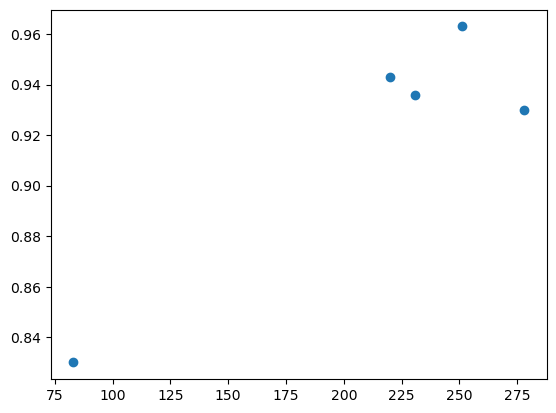

In [12]:
x=[231,251,278,83,220]
y=[.936,.963,.930,.83,.943]
plt.scatter(x,y)

In [2]:
### Set-up - Define file location
filename = 'N-CMAPSS_DS02-006.h5'

In [3]:
# Time tracking, Operation time (min):  0.003
t = time.process_time()  

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'))             # W
        X_s_dev = np.array(hdf.get('X_s_dev'))         # X_s
        X_v_dev = np.array(hdf.get('X_v_dev'))         # X_v
        T_dev = np.array(hdf.get('T_dev'))             # T
        Y_dev = np.array(hdf.get('Y_dev'))             # RUL  
        A_dev = np.array(hdf.get('A_dev'))             # Auxiliary

        # Test set
        W_test = np.array(hdf.get('W_test'))           # W
        X_s_test = np.array(hdf.get('X_s_test'))       # X_s
        X_v_test = np.array(hdf.get('X_v_test'))       # X_v
        T_test = np.array(hdf.get('T_test'))           # T
        Y_test = np.array(hdf.get('Y_test'))           # RUL  
        A_test = np.array(hdf.get('A_test'))           # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                          
W = np.concatenate((W_dev, W_test), axis=0)  
X_s = np.concatenate((X_s_dev, X_s_test), axis=0)
X_v = np.concatenate((X_v_dev, X_v_test), axis=0)
T = np.concatenate((T_dev, T_test), axis=0)
Y = np.concatenate((Y_dev, Y_test), axis=0) 
A = np.concatenate((A_dev, A_test), axis=0) 
    
print('')
print("Operation time (min): " , (time.process_time()-t)/60)
print('')
print ("W shape: " + str(W.shape))
print ("X_s shape: " + str(X_s.shape))
print ("X_v shape: " + str(X_v.shape))
print ("T shape: " + str(T.shape))
print ("A shape: " + str(A.shape))


Operation time (min):  0.03177423333333333

W shape: (6517190, 4)
X_s shape: (6517190, 14)
X_v shape: (6517190, 14)
T shape: (6517190, 10)
A shape: (6517190, 4)


In [4]:
#add index columns to help in restructuring
X_c=np.concatenate((A[:,:2],X_s,X_v),axis=1)

# Baseline LSTM model on NCMAPSS! Reshape takes sliding windows size w from middle k timestamps (k is "kernel") 


In [7]:
#approach 3: sliding window across all flights and units, #kernel samples from each flight
def reshape(arr,kernel,window): #recall this was built with X_c in mind!!
    #data points are sliding windows size w
    #first grab number of flights
    f=0
    for i in np.unique(arr[:,0]):
        dub=arr[arr[:,0]==i]
        f+=np.max(dub[:,1])
    trim=arr[:,2:] #get rid of indices
    k=trim.shape[1] #only after you've deleted unnecessary features!!!;
    X=np.zeros((int(kernel*f),window,6))
    y=np.zeros((int(kernel*f),))
    t_ticker=0
    from sklearn.preprocessing import MinMaxScaler
    indexer=[2,4,6,13,17,28]
    for i,n in enumerate(np.unique(arr[:,0])):
        dub=arr[arr[:,0]==n] #unit
        for j in np.unique(dub[:,1]):
            bub=dub[dub[:,1]==j] #flight
            sub=MinMaxScaler().fit_transform(bub)
            #sub=dub[dub[:,1]==j]
            #t_tocker=0
            t_tocker=int(len(sub)//2-kernel//2)
            for k in range(kernel):
                rub=sub[t_tocker:(t_tocker+window),:]
                X[t_ticker,:,:]+=rub[:,indexer] #should be dim (window,k)
                y[t_ticker]+=len(sub)-(t_tocker+window)
                t_ticker+=1
                t_tocker+=1
    return X,y

In [8]:
X_tr,y_tr=reshape(X_c,kernel=200,window=30)

In [9]:
#imports for LSTM
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError,R2Score
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [11]:
a=np.arange(len(X_tr))
tr_ind=np.random.randint(0,len(X_tr),int(0.8*len(X_tr)))
te_ind=np.delete(a,tr_ind)
X_train=X_tr[tr_ind]
y_train=y_tr[tr_ind]
X_test=X_tr[te_ind]
y_test=y_tr[te_ind]

In [105]:
#construct RNN
model=Sequential() #each xi is run of n timestamps and we are targeting RUL for each 
model.add(LSTM(100,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2]))) #input layer
model.add(LSTM(100,return_sequences=False)) #hidden layer
model.add(Dense(100,'relu')) #activation function
model.add(Dense(1,'linear')) #output
cp=ModelCheckpoint('modelnew.h5',save_best_only=True) #to save the best model
model.compile(loss='MeanSquaredError',optimizer=Adam(learning_rate=0.01),metrics=['R2Score']) #set the loss function optimizer and metric

In [106]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 100)           42800     
                                                                 
 lstm_4 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 133401 (521.10 KB)
Trainable params: 133401 (521.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [107]:
model.fit(X_train,y_train,validation_split=0.3,epochs=20,callbacks=[cp]) #fit the model
model=load_model('modelnew.h5')

#X and y appear to be what I want them to be, scaled, matching.
#something about the setup of this model?
#worth a deep dive into the architecture


Epoch 1/20
2268/2268 [==============================] - 45s 19ms/step - loss: 4903140.5000 - r2_score: -0.1274 - val_loss: 2961662.7500 - val_r2_score: 0.3239
Epoch 2/20
   9/2268 [..............................] - ETA: 36s - loss: 3576168.7500 - r2_score: 0.2843

/Users/alexanderbeyer/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2268/2268 [==============================] - 43s 19ms/step - loss: 1878283.0000 - r2_score: 0.5681 - val_loss: 1376960.5000 - val_r2_score: 0.6857
Epoch 3/20
2268/2268 [==============================] - 43s 19ms/step - loss: 981405.1250 - r2_score: 0.7743 - val_loss: 648957.8750 - val_r2_score: 0.8519
Epoch 4/20
2268/2268 [==============================] - 43s 19ms/step - loss: 542819.0000 - r2_score: 0.8752 - val_loss: 893102.5000 - val_r2_score: 0.7961
Epoch 5/20
2268/2268 [==============================] - 43s 19ms/step - loss: 436434.0000 - r2_score: 0.8996 - val_loss: 277767.6250 - val_r2_score: 0.9366
Epoch 6/20
2268/2268 [==============================] - 43s 19ms/step - loss: 340222.0625 - r2_score: 0.9218 - val_loss: 240051.3125 - val_r2_score: 0.9452
Epoch 7/20
2268/2268 [==============================] - 43s 19ms/step - loss: 280636.8125 - r2_score: 0.9355 - val_loss: 174105.0156 - val_r2_score: 0.9603
Epoch 8/20
2268/2268 [==============================] - 43s 19ms/step - l

In [108]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 30, 100)           42800     
                                                                 
 lstm_4 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 133401 (521.10 KB)
Trainable params: 133401 (521.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [109]:
preds=model.predict(X_test)
print(mean_absolute_error(y_test,preds),r2_score(y_test,preds))

1823/1823 [==============================] - 11s 6ms/step
236.34453927776548 0.9678604021321221


In [13]:
#now a baseline RF regressor to compare
#we'll take feature means across the phase and kernel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

In [14]:
means=np.zeros((648,28))
y_rf=np.zeros((648,))
ticker=0
indexer=[2,4,6,13,17,28]
for i in np.unique(X_c[:,0]):
    dub=X_c[X_c[:,0]==i]
    tocker=0
    for j in np.unique(dub[:,1]):
        sub=dub[dub[:,1]==j]
        mid=len(sub)//2
        sub=sub[mid-500:mid+500,2:] #early phase
        y_rf[ticker]+=len(dub)-(1000+tocker)
        means[ticker]+=np.array(np.mean(sub,axis=0)) #feature means
        ticker+=1
        tocker+=1

#figure out this code-should be easy. then run RF regressor on means.


In [15]:
rf_model=RandomForestRegressor(n_estimators=100,max_depth=5).fit(means,y_rf)

In [16]:
a=np.arange(len(means))
tr_ind=np.random.randint(0,len(means),int(0.8*len(means)))
te_ind=np.delete(a,tr_ind)
X_train=means[tr_ind]
y_train=y_rf[tr_ind]
X_test=means[te_ind]
y_test=y_rf[te_ind]

In [17]:
preds=rf_model.predict(X_test)

In [18]:
r2_score(y_test,preds)

0.7760324716718483